In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
import statsmodels.api as sm
from typing import Tuple
from matplotlib.pyplot import figure
from datetime import date
from math import exp

In [30]:
riskFreeRate = .16

In [31]:
from gbm import simulateGBM

S = 100.
K = 100.
stockVolatility = .4
stockDrift = .16
T = 1.
timeSteps = 5000
simulations = 100

stockGBM = simulateGBM(
    spotPrice=S,
    volatility=stockVolatility,
    drift=stockDrift,
    maturity=T,
    stepNumber=timeSteps,
    simulationNumber=simulations
)

stockGBM.shape

(5000, 100)

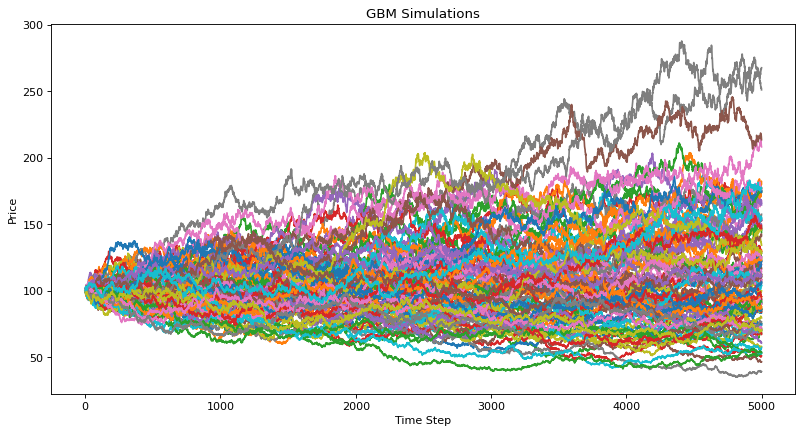

In [32]:
figure(figsize=(12, 6), dpi=80)

plt.plot(stockGBM)
plt.title("GBM Simulations")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()

#### In integral form:

$$
    X_t - V(t, S_T) = \underbrace{\frac{X_0 - V(0, S_0)}{D_t}}_{\text{Premium component}} + \underbrace{\frac{1}{D_t} \int_0^t D_u (r_t - r) \left(V(u, S_u) - \frac{\partial V}{\partial s}(u, S_u) S_u \right)du}_{\text{Funding component}}
$$
$$
+ \underbrace{\frac{1}{D_t} \int_0^t \left(\Delta_u - \frac{\partial V}{\partial s}(u, S_u) \right) d(D_u S_u)}_{\text{Delta component}} + \underbrace{\frac{1}{2} \frac{1}{D_t} \int_0^t D_u \frac{\partial^2 V}{\partial s^2}(u, S_u) S_u^2(\sigma^2 - \sigma_t^2) du}_{\text{Gamma component}}
$$

In [33]:
def PVPutBS(
    spotPrices: np.array,
    strike: float,
    maturity: float,
    riskFreeRate: float,
    volatility: float
) -> np.array:
    """
    Input parameters:
    spotPrices - array of spot prices
    strike - option strike
    maturity - option maturity
    riskFreeRate - current risk free rate 
    volatility - implied BS volatility
    
    Returns:
    np.array of option prices
    """

    d1 = (np.log(spotPrices / strike) + (riskFreeRate + 0.5 *
          volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))
    d2 = d1 - volatility * np.sqrt(maturity)

    return strike * np.exp(-riskFreeRate * maturity) * norm.cdf(d2) - spotPrices * norm.cdf(d1)

In [34]:
def DeltaPutBS(
    spotPrices: np.array,
    strike: float,
    maturity: float,
    riskFreeRate: float,
    volatility: float
) -> np.array:
    """
    Input parameters:
    spotPrices - array of spot prices
    strike - option strike
    maturity - option maturity
    riskFreeRate - current risk free rate 
    volatility - implied BS volatility
    
    Returns:
    np.array of option deltas
    """

    d1 = (np.log(spotPrices / strike) + (riskFreeRate + 0.5 *
          volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))

    return -norm.cdf(d1)

In [35]:
def GammaPutBS(
    spotPrices: np.array,
    strike: float,
    maturity: float,
    riskFreeRate: float,
    volatility: float
) -> np.array:
    """
    Input parameters:
    spotPrices - array of spot prices
    strike - option strike
    maturity - option maturity
    riskFreeRate - current risk free rate 
    volatility - implied BS volatility
    
    Returns:
    np.array of option gammas
    """

    d1 = (np.log(spotPrices / strike) + (riskFreeRate + 0.5 *
          volatility ** 2) * maturity) / (volatility * np.sqrt(maturity))

    return - norm.pdf(d1) / (spotPrices * volatility * np.sqrt(maturity))

In [36]:
optionVolatility = .4

In [37]:
pv = PVPutBS(
    spotPrices=S,
    strike=K,
    maturity=T,
    riskFreeRate=riskFreeRate,
    volatility=optionVolatility
)
delta = DeltaPutBS(
    spotPrices=S,
    strike=K,
    maturity=T,
    riskFreeRate=riskFreeRate,
    volatility=optionVolatility
)
gamma = GammaPutBS(
    spotPrices=S,
    strike=K,
    maturity=T,
    riskFreeRate=riskFreeRate,
    volatility=optionVolatility
)

pv, delta, gamma

(-23.213431865302255, -0.7257468822499265, -0.008330615072294992)

In [38]:
S = 100.
K = 100.
stockVolatility = .3
optionVolatility = .4
premiumVolatility = .35
hedgingVolatility = .2
stockDrift = .1
riskFreeRate = .16
riskFreeRateModel = .25
T = 1.
timeSteps = 1000
simulations = 10

In [39]:
def simulatePortfolio(
    spotPrice: float,
    spotDrift: float,
    strike: float,
    volatilityStock: float,
    volatilityOption: float,
    volatilityPremium: float,
    volatilityHedging: float,
    riskFreeRate: float,
    riskFreeRateModel: float,
    stepNumber: int,
    maturity: float,
    simulations: int
) -> Tuple[np.array, float]:
    """
    Input parameters:
    spotPrice - initial asset price,
    spotDrift - asset drift, 
    strike - option strike,
    volatilityStock - asset volatility,
    volatilityOption - implied volatility,
    volatilityPremium - initial purchasing implied volatility,
    volatilityHedging - hedging implied volatility,
    riskFreeRate - current risk free rate on the market,
    riskFreeRateModel -- rfr used in BSM model
    stepNumber - number of steps in sumilation,
    maturity - option maturity,
    simulations - number of stock paths simulations
    
    Returns:
    np.array of portfolio PnL and y-axis scale according to the first option price
    """

    stockGBM = simulateGBM(spotPrice, volatilityStock,
                           spotDrift, maturity, stepNumber, simulations)

    dt = maturity / stepNumber
    putPV = np.empty((0, simulations))
    deltaHedging = np.empty((0, simulations))
    deltaOption = np.empty((0, simulations))
    gammaOption = np.empty((0, simulations))
    allDf = np.empty((0, 1))

    for t in range(stockGBM.shape[0]):
        T = maturity - dt * t
        df = exp(-riskFreeRate * t * dt)
        allDf = np.vstack((allDf, df))
        prevDf = exp(-riskFreeRate * (t - 1) * dt)
        putPV = np.vstack(
            (
                putPV,
                PVPutBS(stockGBM[t, :], strike, T,
                         riskFreeRateModel, volatilityOption)
            )
        )
        deltaHedging = np.vstack(
            (
                deltaHedging,
                DeltaPutBS(stockGBM[t, :], strike, T,
                            riskFreeRateModel, volatilityHedging)
            )
        )
        deltaOption = np.vstack(
            (
                deltaOption,
                DeltaPutBS(stockGBM[t, :], strike, T,
                            riskFreeRateModel, volatilityOption)
            )
        )
        gammaOption = np.vstack(
            (
                gammaOption,
                GammaPutBS(stockGBM[t, :], strike, T,
                            riskFreeRateModel, volatilityOption)
            )
        )

        if t == 0:
            initialHedgeValue = PVPutBS(
                stockGBM[t, :], strike, T, riskFreeRateModel, volatilityPremium)
            optionValue = putPV[t, :]
            premiumComponent = np.array([initialHedgeValue - optionValue])
            fundingComponent = np.zeros((simulations))
            deltaComponent = np.zeros((simulations))
            gammaComponent = np.zeros((simulations))
        else:
            optionValue = np.vstack((optionValue, putPV[t, :]))
            initialHedgeValue = np.vstack(
                (
                    initialHedgeValue,
                    initialHedgeValue[t - 1]
                    + deltaHedging[t - 1, :] *
                    (stockGBM[t, :] - stockGBM[t - 1, :])
                    + riskFreeRate *
                    (initialHedgeValue[t - 1] -
                     deltaHedging[t - 1, :] * stockGBM[t - 1, :]) * dt
                )
            )
            premiumComponent = np.vstack(
                (premiumComponent, premiumComponent[t - 1, :]))
            fundingComponent = np.vstack(
                (
                    fundingComponent,
                    fundingComponent[t - 1] +
                    prevDf * (riskFreeRate - riskFreeRateModel) *
                    (putPV[t - 1, :] - deltaOption[t - 1, :]
                     * stockGBM[t - 1, :]) * dt
                )
            )
            deltaComponent = np.vstack(
                (
                    deltaComponent,
                    deltaComponent[t - 1] +
                    (deltaHedging[t - 1, :] - deltaOption[t - 1, :]) *
                    (df * stockGBM[t, :] - prevDf * stockGBM[t - 1, :])
                )
            )
            gammaComponent = np.vstack(
                (
                    gammaComponent,
                    gammaComponent[t - 1] +
                    .5 * prevDf * gammaOption[t - 1, :] * stockGBM[t - 1, :] ** 2 * (
                        volatilityOption ** 2 - volatilityStock ** 2) * dt
                )
            )
    portfolio = initialHedgeValue - optionValue - 1 / allDf * (
        premiumComponent + fundingComponent + deltaComponent + gammaComponent
    )

    return portfolio, optionValue[0][0]

In [40]:
PnL, ymax = simulatePortfolio(
    spotPrice=S,
    spotDrift=stockDrift,
    strike=K,
    volatilityStock=stockVolatility,
    volatilityOption=optionVolatility,
    volatilityPremium=premiumVolatility,
    volatilityHedging=hedgingVolatility,
    riskFreeRate=riskFreeRate,
    riskFreeRateModel=riskFreeRateModel,
    stepNumber=timeSteps,
    maturity=T,
    simulations=simulations
)

In [41]:
PnL.shape

(1000, 10)

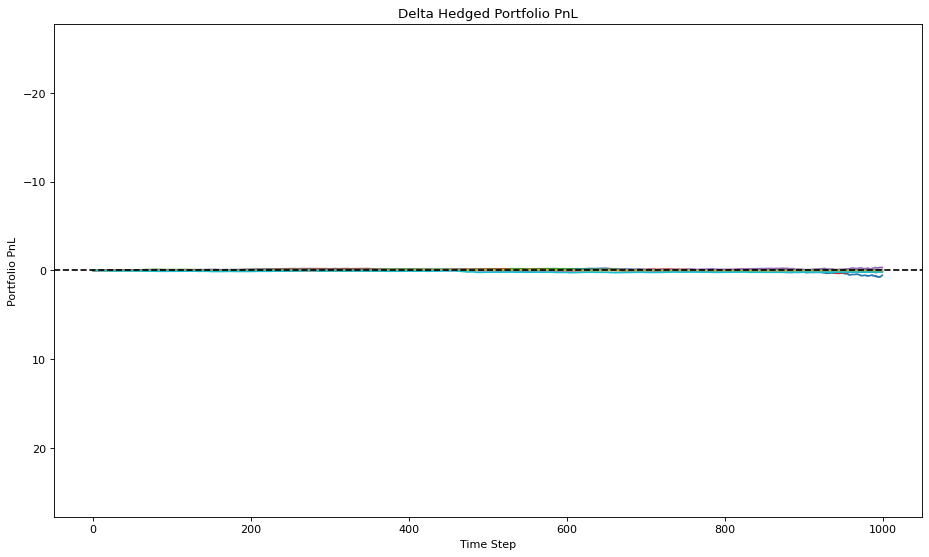

In [42]:
figure(figsize=(14, 8), dpi=80)

# samplePath = 90

plt.plot(PnL)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Delta Hedged Portfolio PnL")
plt.xlabel("Time Step")
plt.ylabel("Portfolio PnL")
plt.ylim(-ymax, ymax)
plt.show()